c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 57767.06 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.673900,0.638008,0.733248,0.717865
2,0.514400,0.640131,0.751755,0.742436
3,0.359300,0.731656,0.744097,0.748867
4,0.304800,0.787070,0.759413,0.755933


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_23120\664199115.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_2 = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.381500,0.681495,0.760051,0.754653
2,0.398800,0.696234,0.758137,0.748429
3,0.324800,0.761456,0.762604,0.756347
4,0.294400,0.860483,0.759413,0.752151


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_23120\664199115.py:156: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_3 = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.175600,0.906708,0.754946,0.751371
2,0.354200,0.793211,0.757498,0.748081
3,0.285800,0.808862,0.756222,0.749513


Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.59      0.39      0.47       361
    Positive       0.76      0.85      0.80       654
    Negative       0.77      0.83      0.80       571

    accuracy                           0.74      1586
   macro avg       0.71      0.69      0.69      1586
weighted avg       0.72      0.74      0.72      1586



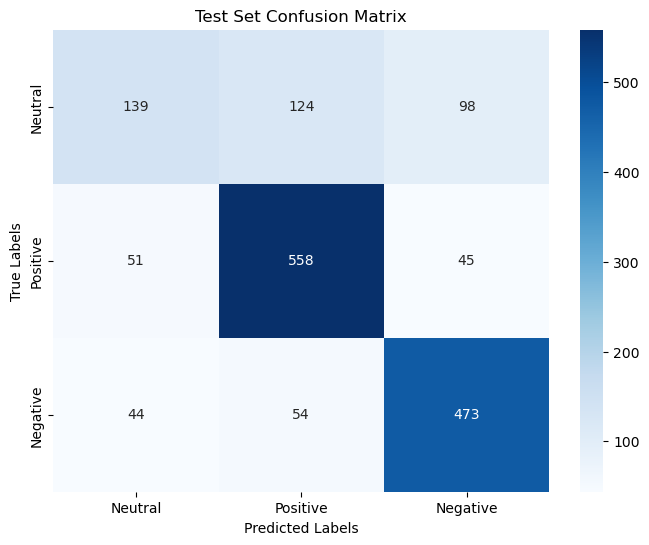

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# Load datasets
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Check for missing values and shuffle
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# === STEP 1: First Training and Save as bbft1 ===
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)

training_args_1 = TrainingArguments(
    output_dir='./results_bbft1',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs_bbft1',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

trainer_1 = Trainer(
    model=model,
    args=training_args_1,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_1.train()
trainer_1.save_model("bbft1")
tokenizer.save_pretrained("bbft1")

# === STEP 2: Load bbft1 and Retrain, Save as bbft2 ===
model = AutoModelForSequenceClassification.from_pretrained("bbft1").to(device)

training_args_2 = TrainingArguments(
    output_dir='./results_bbft2',
    evaluation_strategy='epoch',
    learning_rate=1e-5,  # smaller LR for retraining
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs_bbft2',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=2
)

trainer_2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_2.train()
trainer_2.save_model("bbft2")
tokenizer.save_pretrained("bbft2")

# === STEP 3: Load bbft2 and Retrain Again, Save as bbft3 ===
model = AutoModelForSequenceClassification.from_pretrained("bbft2").to(device)

training_args_3 = TrainingArguments(
    output_dir='./results_bbft3',
    evaluation_strategy='epoch',
    learning_rate=5e-6,  # even smaller LR for fine refinements
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_bbft3',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=1
)

trainer_3 = Trainer(
    model=model,
    args=training_args_3,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_3.train()
trainer_3.save_model("bbft3")
tokenizer.save_pretrained("bbft3")

# === Final Evaluation on Test Set ===
test_output = trainer_3.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
